# Big Blue Bus nearest neighbor comparison

* What would happen if we allowed all the full vp to be used to find nearest neighbor, instead of removing the opposite direction?
* The monotonically increasing condition is set later, could it catch the errors that way?

In [1]:
import geopandas as gpd
import pandas as pd

from segment_speed_utils import helpers, neighbor
from segment_speed_utils.project_vars import SEGMENT_GCS, GTFS_DATA_DICT
from shared_utils import rt_dates

analysis_date = rt_dates.DATES["apr2024"]

In [2]:
import numpy as np
import sys
sys.path.append("scripts/")
import nearest_vp_to_stop

WGS84 = "EPSG:4326"

In [3]:
bbb_trips = helpers.import_scheduled_trips(
    analysis_date,
    filters = [("name", "==", "Big Blue Bus Schedule")],
    columns = ["gtfs_dataset_key", "trip_instance_key"],
    get_pandas = True
)

bbb_key = bbb_trips.schedule_gtfs_dataset_key.iloc[0]
subset_trips = bbb_trips.trip_instance_key.unique()

## Construct proxy stop times

In [4]:
def construct_stop_times(
    analysis_date: str, 
    subset_trips: list
) -> gpd.GeoDataFrame:

    # Grab the relevant stop times rows
    # will need to concatenate RT stop times (all trips) 
    # with additional segments for speedmaps
    rt_stop_times = (
        nearest_vp_to_stop.stop_times_for_all_trips(analysis_date)
        .query('trip_instance_key in @subset_trips')
    )

    proxy_stop_times = (
        nearest_vp_to_stop.stop_times_for_speedmaps(analysis_date)
        .query('trip_instance_key in @subset_trips')
    )

    bbb_stop_times = pd.concat(
        [rt_stop_times, proxy_stop_times], 
        axis=0, ignore_index=True
    )
    
    return bbb_stop_times

bbb_stop_times = construct_stop_times(analysis_date, subset_trips)

## Merge stop and get nearest snap (`neighbor`)

In [5]:
# This is with opposite direction removed
gdf = neighbor.merge_stop_vp_for_nearest_neighbor(
    bbb_stop_times,
    analysis_date,
    filters = [[("trip_instance_key", "in", subset_trips)]]
)

In [6]:
# Try a version without removing vp points
# and allow nearest neighbor to select from any direction
vp_full = gpd.read_parquet(
    f"{SEGMENT_GCS}condensed/vp_condensed_{analysis_date}.parquet",
    columns = ["trip_instance_key", "vp_idx", 
               "location_timestamp_local", 
               "geometry"],
    filters = [[("trip_instance_key", "in", subset_trips)]]
).rename(columns = {
    "vp_idx": "trip_vp_idx",
    "geometry": "trip_geometry"
}).set_geometry("trip_geometry").to_crs(WGS84)

gdf2 = pd.merge(
    bbb_stop_times.rename(
        columns = {
            "geometry": "stop_geometry"}
    ).set_geometry("stop_geometry").to_crs(WGS84),
    vp_full.rename(
        columns = {
            "geometry": "vp_geometry"
        }),
    on = ["trip_instance_key"],
    how = "inner"
)

In [7]:
# this list comes from an adapted version of 
# GTFS_DATA_DICT stop_pair_cols
merge_cols = ["stop_id", "stop_pair", "stop_sequence", "stop_sequence1", 
          "stop_geometry", "stop_primary_direction", 
          "shape_array_key", "trip_instance_key"]

gdf_results = pd.merge(
    gdf,
    gdf2,
    on = merge_cols,
    how = "inner"
)

In [8]:
gdf_results.dtypes

trip_instance_key             object
shape_array_key               object
stop_sequence                  int64
stop_id                       object
stop_pair                     object
stop_primary_direction        object
stop_geometry               geometry
stop_sequence1               float64
vp_geometry                 geometry
vp_idx                        object
trip_vp_idx                   object
location_timestamp_local      object
trip_geometry               geometry
dtype: object

In [9]:
nearest_vp_idx = np.vectorize(neighbor.add_nearest_vp_idx)( 
    gdf_results.vp_geometry, gdf_results.stop_geometry, gdf_results.vp_idx
)

nearest_vp_idx2 = np.vectorize(neighbor.add_nearest_vp_idx)( 
    gdf_results.trip_geometry, gdf_results.stop_geometry, gdf_results.trip_vp_idx
)

In [10]:
gdf_results = gdf_results.assign(
    nearest_vp_idx = nearest_vp_idx,
    nearest_vp_idx2 = nearest_vp_idx2
)

In [11]:
gdf_results.shape, gdf_results[
    gdf_results.nearest_vp_idx != gdf_results.nearest_vp_idx2
].shape

((36719, 15), (1503, 15))

If we allow even opposite directions to show up in the nearest neighbor, about 4.1% of the rows would have different results for which `vp_idx` is selected.

About 2/3 of these are -1 or +1, which probably wouldn't change the result that much. The other 1/3 have differences more than 1, which could change the result, since the trio of points allows for a difference of 1, but not more to interpolate.

In [12]:
gdf_results.shape, gdf_results[
    gdf_results.nearest_vp_idx != gdf_results.nearest_vp_idx2].shape

((36719, 15), (1503, 15))

In [13]:
diff_df = gdf_results[
    gdf_results.nearest_vp_idx != gdf_results.nearest_vp_idx2]

diff_df = diff_df.assign(
    vp_idx_diff = diff_df.nearest_vp_idx - diff_df.nearest_vp_idx2
)

diff_df["vp_idx_diff"].shape, diff_df[
    abs(diff_df.vp_idx_diff) > 1].shape

((1503,), (571, 16))

<AxesSubplot:>

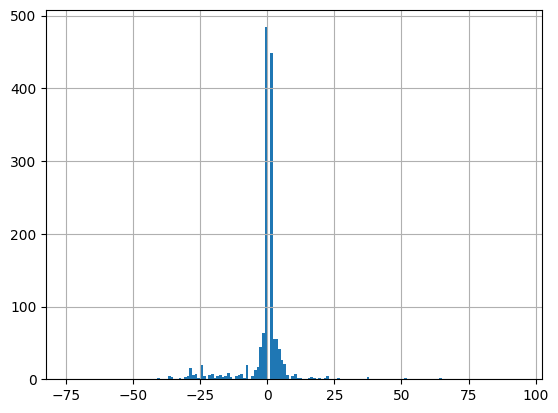

In [14]:
diff_df.vp_idx_diff.hist(bins = range(
    diff_df.vp_idx_diff.min(), 
    diff_df.vp_idx_diff.max(), 
    1)
                        )

In [15]:
diff_df.vp_idx_diff.describe()

count    1503.000000
mean       -1.375915
std        10.011931
min       -74.000000
25%        -1.000000
50%        -1.000000
75%         1.000000
max        95.000000
Name: vp_idx_diff, dtype: float64

## Add trio (`neighbor`)

In [16]:
import shapely
def add_trio_cols(
    gdf2: gpd.GeoDataFrame, 
    nearest_vp_col: str,
):

    nearest_vp_idx_series = []    
    vp_trio_series = []
    time_trio_series = []
    coords_trio_series = []
    
    for row in gdf2.itertuples():
        vp_trio, time_trio, coords_trio = neighbor.add_trio(
            getattr(row, nearest_vp_col), 
            np.asarray(getattr(row, "trip_vp_idx")),
            np.asarray(getattr(row, "location_timestamp_local")),
            np.asarray(getattr(row, "trip_geometry").coords),
        )
        
        vp_trio_series.append(vp_trio)
        time_trio_series.append(time_trio)
        coords_trio_series.append(shapely.LineString(coords_trio))
                
    drop_cols = [
        "location_timestamp_local",
        "trip_vp_idx", "trip_geometry"
    ]
    
    gdf2 = gdf2.assign(
        vp_idx_trio = vp_trio_series,
        location_timestamp_local_trio = time_trio_series,
        vp_coords_trio = gpd.GeoSeries(coords_trio_series, crs = WGS84)
    ).drop(columns = drop_cols)
    
    return gdf2

In [17]:
gdf_results1 = add_trio_cols(gdf_results, "nearest_vp_idx")
gdf_results2 = add_trio_cols(gdf_results, "nearest_vp_idx2")

In [18]:
trio_results = pd.merge(
    gdf_results1,
    gdf_results2.rename(columns = {
        "vp_idx": "vp_idx2",
        
        "vp_idx_trio": "vp_idx_trio2",
        "location_timestamp_local_trio": "location_timestamp_local_trio2",
        "vp_coords_trio": "vp_coords_trio2"
    }),
    on = merge_cols + ["vp_geometry", "nearest_vp_idx", "nearest_vp_idx2"],
    how = "inner",
)

## Interpolate arrival

In [19]:
trio_results.dtypes

trip_instance_key                   object
shape_array_key                     object
stop_sequence                        int64
stop_id                             object
stop_pair                           object
stop_primary_direction              object
stop_geometry                     geometry
stop_sequence1                     float64
vp_geometry                       geometry
vp_idx                              object
nearest_vp_idx                       int64
nearest_vp_idx2                      int64
vp_idx_trio                         object
location_timestamp_local_trio       object
vp_coords_trio                    geometry
vp_idx2                             object
vp_idx_trio2                        object
location_timestamp_local_trio2      object
vp_coords_trio2                   geometry
dtype: object

In [20]:
PROJECT_CRS = "EPSG:3310"
import interpolate_stop_arrival

trip_stop_cols = ["trip_instance_key", "stop_sequence", "stop_sequence1"]

def interpolate_me(
    df: gpd.GeoDataFrame,
    analysis_date: str,
):
    df = df.assign(
        stop_geometry = df.stop_geometry.to_crs(PROJECT_CRS),
        vp_coords_trio = df.vp_coords_trio.to_crs(PROJECT_CRS)
    )

    shapes = helpers.import_scheduled_shapes(
        analysis_date,
        columns = ["shape_array_key", "geometry"],
        crs = PROJECT_CRS
    ).dropna(subset="geometry")

    gdf = pd.merge(
        df,
        shapes.rename(columns = {"geometry": "shape_geometry"}),
        on = "shape_array_key",
        how = "inner"
    )

    del df, shapes

    stop_meters_series = []
    stop_arrival_series = []
    
    for row in gdf.itertuples():
        
        stop_meters, interpolated_arrival = interpolate_stop_arrival.project_points_onto_shape(
            getattr(row, "stop_geometry"),
            getattr(row, "vp_coords_trio"),
            getattr(row, "shape_geometry"),
            getattr(row, "location_timestamp_local_trio")
        )
        
        stop_meters_series.append(stop_meters)
        stop_arrival_series.append(interpolated_arrival)

    results = gdf.assign(
        stop_meters = stop_meters_series,
        arrival_time = stop_arrival_series,
    )[trip_stop_cols + ["shape_array_key", "stop_id", 
         "stop_meters", "arrival_time"]
     ].sort_values(
        trip_stop_cols
    ).reset_index(drop=True)
    
    
    results = interpolate_stop_arrival.enforce_monotonicity_and_interpolate_across_stops(
        results, trip_stop_cols)
    
    return results

In [21]:
gdf_interp1 = interpolate_me(gdf_results1, analysis_date)

/opt/conda/lib/python3.9/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [22]:
gdf_interp2 = interpolate_me(gdf_results2, analysis_date)

/opt/conda/lib/python3.9/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [23]:
interp_results = pd.merge(
    gdf_interp1,
    gdf_interp2.rename(columns = {
        "stop_meters": "stop_meters2",
        "arrival_time": "arrival_time2"
    }),
    on = trip_stop_cols + ["shape_array_key", "stop_id"],
    how = "inner",
)

About 4.5% have different interpolated arrival time results. Before, about 4.1% have different nearest vp selected, and about 1/3 of those had differences greater than 1. 

But overall, it results in about 4.5% of different interpolated arrival times.

**Conclusion**:
* A small number of rows are affected, but interestingly, the speeds that come out differ by a lot. Speeds can swing wildly, so it is sensitive to what point is selected. If it didn't vary a lot, then speeds would only differ by 1 or 2 mph, but not in the bounds that we see.
* If we think about where buses dwell, it would be near stops, so we can expect that sensitive results are concentrated where we care about measuring arrival.
* We should definitely include `dwell_time` in vp, but once we account for that, we would actually narrow down the possibilities we select, and that's a good thing.

In [24]:
interp_results.shape, interp_results[
    interp_results.arrival_time != interp_results.arrival_time2
].shape

((36483, 9), (1624, 9))

## Speeds

In [25]:
from segment_speed_utils import segment_calcs

def speed_calculation(df: pd.DataFrame):
    trip_cols = ["trip_instance_key"]

    df = segment_calcs.convert_timestamp_to_seconds(
        df, ["arrival_time"]
    ).sort_values(trip_stop_cols).reset_index(drop=True)
    
    df = df.assign(
        subseq_arrival_time_sec = (df.groupby(trip_cols, 
                                             observed=True, group_keys=False)
                                  .arrival_time_sec
                                  .shift(-1)
                                 ),
        subseq_stop_meters = (df.groupby(trip_cols, 
                                        observed=True, group_keys=False)
                             .stop_meters
                             .shift(-1)
                            )
    )

    speed = df.assign(
        meters_elapsed = df.subseq_stop_meters - df.stop_meters, 
        sec_elapsed = df.subseq_arrival_time_sec - df.arrival_time_sec,
    ).pipe(
        segment_calcs.derive_speed, 
        ("stop_meters", "subseq_stop_meters"), 
        ("arrival_time_sec", "subseq_arrival_time_sec")
    )
    
    return speed

In [26]:
drop_me = [
    "arrival_time_sec", "subseq_arrival_time_sec",
    "subseq_stop_meters"
]
speed1 = speed_calculation(gdf_interp1).drop(columns = drop_me)
speed2 = speed_calculation(gdf_interp2).drop(columns = drop_me)

In [27]:
speed_results = pd.merge(
    speed1,
    speed2.rename(columns = {
        "stop_meters": "stop_meters2",
        "arrival_time": "arrival_time2",
        "meters_elapsed": "meters_elapsed2",
        "sec_elapsed": "sec_elapsed2",
        "speed_mph": "speed_mph2"
    }),
    on = trip_stop_cols + ["shape_array_key", "stop_id"],
    how = "inner",
)

This magnifies to about 5.5% different speeds

In [28]:
speed_results.shape, speed_results[
    (speed_results.speed_mph != speed_results.speed_mph2) & 
    (speed_results.speed_mph.notna()) & 
    (speed_results.speed_mph < 100_000) # remove infinity
].shape

((36483, 15), (1997, 15))

In [29]:
speed_results = speed_results.assign(
    speed_diff = speed_results.speed_mph - speed_results.speed_mph2
)

In [30]:
speed_results.speed_diff.describe()

count    33593.0
mean         NaN
std          NaN
min         -inf
25%          0.0
50%          0.0
75%          0.0
max          inf
Name: speed_diff, dtype: float64

<AxesSubplot:>

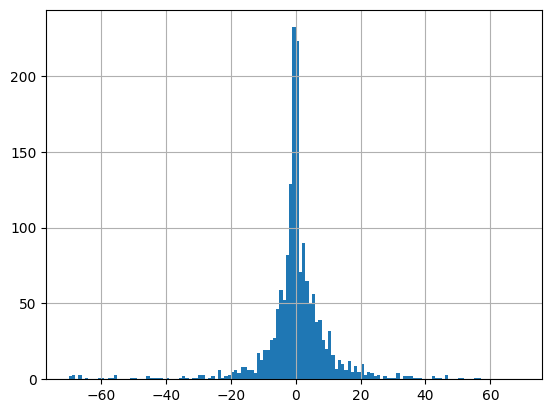

In [31]:
speed_results[
    speed_results.speed_diff != 0
].speed_diff.hist(bins=range(-70, 70, 1))

In [32]:
speed_results[
    (speed_results.speed_diff != 0) & 
    (speed_results.speed_mph.notna()) & 
    (speed_results.speed_mph < 100_000)
].sort_values(["trip_instance_key", "arrival_time"])[
    ["arrival_time", "arrival_time2", 
     "speed_mph", "speed_mph2", "speed_diff"]]

,arrival_time,arrival_time2,speed_mph,speed_mph2,speed_diff
1,2024-04-17 08:16:28,2024-04-17 08:16:28,10.076577,6.883077,3.193500
2,2024-04-17 08:20:10,2024-04-17 08:21:53,6.301408,12.091892,-5.790483
3,2024-04-17 08:26:05,2024-04-17 08:24:58,79.892857,23.547368,56.345489
147,2024-04-17 12:16:41,2024-04-17 12:16:41,15.851257,18.648538,-2.797281
148,2024-04-17 12:18:01,2024-04-17 12:17:49,18.072365,18.695550,-0.623185
...,...,...,...,...,...
36442,2024-04-17 13:00:48,2024-04-17 13:03:55,9.643567,86.792099,-77.148533
36443,2024-04-17 13:01:51,2024-04-17 13:04:02,9.559454,74.269606,-64.710152
36444,2024-04-17 13:03:32,2024-04-17 13:04:15,9.547016,77.967296,-68.420280
36471,2024-04-17 13:48:13,2024-04-17 13:48:13,6.323238,5.025310,1.297928


In [33]:
SEGMENT_FILE = GTFS_DATA_DICT.speedmap_segments.segments_file

segment_gdf = gpd.read_parquet(
    f"{SEGMENT_GCS}{SEGMENT_FILE}_{analysis_date}.parquet", 
    filters = [[("trip_instance_key", "in", subset_trips)]]
)

In [34]:
from segment_speed_utils import gtfs_schedule_wrangling

speed_results2 = gtfs_schedule_wrangling.fill_missing_stop_sequence1(
    speed_results)

In [35]:
segment_gdf.shape

(35665, 12)

In [36]:
# address how stop_sequence1 can be missing in speedmap segments
pd.merge(
    segment_gdf,
    speed_results2,
    on = trip_stop_cols + ["shape_array_key"],
    how = "outer",
    indicator = True
)._merge.value_counts()

both          35583
left_only      1165
right_only      900
Name: _merge, dtype: int64

In [37]:
speed_results_gdf = pd.merge(
    segment_gdf,
    speed_results2,
    on = trip_stop_cols + ["shape_array_key"],
    how = "inner",
)

In [38]:
speed_results_gdf.dtypes

trip_instance_key                    object
shape_array_key                      object
stop_id1                             object
stop_sequence                         int64
geometry                           geometry
stop_id2                             object
segment_id                           object
stop_pair                            object
schedule_gtfs_dataset_key            object
route_id                             object
direction_id                        float64
stop_sequence1                      float64
stop_id                              object
stop_meters                         float64
arrival_time                 datetime64[ns]
meters_elapsed                      float64
sec_elapsed                         float64
speed_mph                           float64
stop_meters2                        float64
arrival_time2                datetime64[ns]
meters_elapsed2                     float64
sec_elapsed2                        float64
speed_mph2                      

In [39]:
from shared_utils import rt_utils
import folium

def make_map(gdf):
    drop = ["arrival_time", "arrival_time2"]
    
    print(f"# rows: {len(gdf)}")
    
    print("rows with differences")
    display_table = gdf.sort_values(
        "segment_id"
    ).query('speed_diff != 0')[
        ["segment_id", "speed_mph", "speed_mph2", "speed_diff"]]
    
    display(display_table)
    
    m = gdf.drop(columns = drop).explore(
        "speed_mph",
        tiles = "CartoDB Positron",
        cmap = rt_utils.ZERO_THIRTY_COLORSCALE
    )
    
    m2 = gdf.drop(columns = drop).explore(
        "speed_mph2",
        m=m
    )
    
    folium.LayerControl().add_to(m)
    
    return m

In [40]:
bbb_trips_and_shape = helpers.import_scheduled_trips(
    analysis_date,
    filters = [("trip_instance_key", "in", subset_trips)],
    columns = ["shape_id", "shape_array_key", "trip_instance_key"],
    get_pandas = True
)

In [41]:
set(bbb_trips_and_shape[
    bbb_trips_and_shape.shape_id=="26714"
].trip_instance_key.unique()) & set(
    speed_results_gdf.trip_instance_key.unique())

{'3dfd9bae3724d3f62363a8328696cb4e', '523d9d30ace49b2cc966c2cbaa8e9071'}

In [42]:
one_trip = "523d9d30ace49b2cc966c2cbaa8e9071" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 27
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff


In [43]:
one_trip = "3dfd9bae3724d3f62363a8328696cb4e" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 27
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff


In [44]:
set(bbb_trips_and_shape[
    bbb_trips_and_shape.shape_id=="26751"
].trip_instance_key.unique()) & set(
    speed_results_gdf.trip_instance_key.unique())

{'103ffb4be00deb25a90c82f92d431cb2', 'b7e313991dda4231381e05c871aced54'}

In [45]:
one_trip = "103ffb4be00deb25a90c82f92d431cb2" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 48
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
1770,1623-956-1,18.865186,24.524742,-5.659556
1769,952-1623-1,7.139324,6.632389,0.506934


In [46]:
one_trip = "b7e313991dda4231381e05c871aced54" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 48
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
26202,149-6-1,153.689307,9.692118,143.997188
26201,376-149-1,5.581808,16.745425,-11.163617


In [47]:
set(bbb_trips_and_shape[
    bbb_trips_and_shape.shape_id=="26793"
].trip_instance_key.unique()) & set(
    speed_results_gdf.trip_instance_key.unique())

{'143c56083f8e23bd7ced3a78f81d0f93',
 '167d16535237b35a22bf79d466d5d740',
 '2ab8b3a8c97083f616fba5b08fb36d0c',
 '5403c8f1427707c364f04d3f34be3b4b',
 '604be0c6fe24d8d2e2387de6186f8814',
 '66c7c7215da8fc97c6e620c694aa689c',
 '8c1585f261c194f978e43d39834bca68',
 '9829f32559f856275dfe082b8cac9719',
 'a725e1f77de271e916519186e26ba819',
 'ac0eec3f8bd18ba7c881c96ea7651eb8',
 'dd5bb7fdf34987d8ed372fb62b112443'}

In [48]:
one_trip = "dd5bb7fdf34987d8ed372fb62b112443" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 19
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
30869,1499-1497-1,inf,inf,NaN
30868,1554-1499-1,inf,inf,NaN


/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:931: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:963: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/opt/conda/lib/python3.9/site-packages/branca/colormap.py:193: RuntimeWarning: invalid value encountered in double_scalars
  self.index = [vmin + (vmax-vmin)*i*1./(n-1) for i in range(n)]


In [49]:
one_trip = "167d16535237b35a22bf79d466d5d740" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 19
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
2545,1446-1545-1,12.038936,8.276769,3.762168
2557,1499-1497-1,inf,inf,NaN
2546,1545-1546-1,6.093729,8.198836,-2.105107
2555,1553-1554-1,inf,inf,NaN
2556,1554-1499-1,inf,inf,NaN
2544,698-1446-1,8.206479,8.286934,-0.080456


/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:931: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:963: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/opt/conda/lib/python3.9/site-packages/branca/colormap.py:193: RuntimeWarning: invalid value encountered in double_scalars
  self.index = [vmin + (vmax-vmin)*i*1./(n-1) for i in range(n)]


In [50]:
bbb_trips_and_shape.shape_id.unique()

array(['26714', '26715', '26716', '26717', '26718', '26719', '26720',
       '26721', '26722', '26723', '26724', '26725', '26726', '26727',
       '26729', '26730', '26731', '26732', '26733', '26734', '26735',
       '26736', '26737', '26739', '26740', '26741', '26742', '26743',
       '26744', '26745', '26746', '26748', '26749', '26750', '26751',
       '26752', '26754', '26755', '26756', '26757', '26758', '26759',
       '26761', '26762', '26764', '26765', '26766', '26767', '26768',
       '26770', '26771', '26772', '26773', '26774', '26775', '26776',
       '26778', '26779', '26780', '26783', '26784', '26791', '26793',
       '26794', '26807'], dtype=object)

In [51]:
set(bbb_trips_and_shape[
    bbb_trips_and_shape.shape_id=="26776"
].trip_instance_key.unique()) & set(
    speed_results_gdf.trip_instance_key.unique())

{'2bd2f54886e8fba388fbc240ab9fb6f6',
 '76da1c769ae95a9f7beddf8c767ac445',
 '95003d28b91c57daf4144f2bc2e24dde',
 'd993539eceeacd7253b4b15f057af313'}

In [52]:
one_trip = "76da1c769ae95a9f7beddf8c767ac445" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 30
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
17165,1636-539-1,14.248408,10.859223,3.389184
17166,1636-539-1,14.198296,10.829822,3.368473
17167,1636-539-2,14.230073,10.848669,3.381403
17190,21-4-1,inf,inf,NaN
17191,4-43-1,inf,inf,NaN
17162,532-1636-1,10.859223,14.158228,-3.299005
17163,532-1636-1,10.813418,14.047013,-3.233595
17164,532-1636-2,10.829570,14.113374,-3.283805


/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:931: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:963: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/opt/conda/lib/python3.9/site-packages/branca/colormap.py:193: RuntimeWarning: invalid value encountered in double_scalars
  self.index = [vmin + (vmax-vmin)*i*1./(n-1) for i in range(n)]


In [53]:
one_trip = "d993539eceeacd7253b4b15f057af313" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 30
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
30469,41-469-1,4.004397,4.105137,-0.100740
30470,469-1200-1,11.427923,10.925596,0.502326


In [54]:
set(bbb_trips_and_shape[
    bbb_trips_and_shape.shape_id=="26755"
].trip_instance_key.unique()) & set(
    speed_results_gdf.trip_instance_key.unique())

{'019f9c6edb777d117f355db69a157293',
 '2cae14be171e33a905bbf6e4491594c1',
 '47e0f2bcdf735d7ed20155e10bbc469d',
 '5f815e872bedb557ea592917806dcba3',
 '93a7b7befc2c9adf4e3cbf3242504ac0',
 'a703ab9a7275b50e56b234b72b60a7ac',
 'e33bfee4abc73cae23830c0f66aee6d6',
 'f598cd73601dc63a43d2df6c1356e4bc',
 'f7f86e477bc93b582b24dd512973f356'}

In [55]:
one_trip = "f7f86e477bc93b582b24dd512973f356" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 16
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
34497,1148-1538-1,25.678032,20.075553,5.602480
34487,1150-303-1,13.416990,2.098977,11.318013
34499,1539-1566-1,16.112665,2.484332,13.628334
34501,1541-1543-1,inf,inf,NaN
34502,1543-1409-1,inf,inf,NaN
34500,1566-1541-1,2.130912,3.123959,-0.993047
34494,236-837-1,17.211776,20.080405,-2.868629
34493,689-236-1,12.939802,20.453235,-7.513433
34495,837-840-1,26.475353,20.121268,6.354085
34496,840-1148-1,26.102286,19.984562,6.117723


/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:931: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:963: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/opt/conda/lib/python3.9/site-packages/branca/colormap.py:193: RuntimeWarning: invalid value encountered in double_scalars
  self.index = [vmin + (vmax-vmin)*i*1./(n-1) for i in range(n)]


In [56]:
one_trip = "2cae14be171e33a905bbf6e4491594c1" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 16
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
5766,1148-1538-1,13.801942,13.303077,0.498865
5767,1538-1539-1,13.430701,13.150895,0.279806
5770,1541-1543-1,inf,inf,NaN
5771,1543-1409-1,inf,inf,NaN
5763,236-837-1,13.725847,13.223681,0.502165
5762,689-236-1,11.633950,13.348427,-1.714477
5764,837-840-1,13.719046,13.237676,0.481370
5765,840-1148-1,13.606511,13.185691,0.420820


/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:931: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:963: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
/opt/conda/lib/python3.9/site-packages/branca/colormap.py:193: RuntimeWarning: invalid value encountered in double_scalars
  self.index = [vmin + (vmax-vmin)*i*1./(n-1) for i in range(n)]


In [57]:
# This seems to indicate that unknowns should not be left in our vp_usable
# we should definitely use dwell time so that these get avoided
one_trip = "5f815e872bedb557ea592917806dcba3" 

m = make_map(
    speed_results_gdf[
        speed_results_gdf.trip_instance_key == 
        one_trip], 
)

# rows: 16
rows with differences


,segment_id,speed_mph,speed_mph2,speed_diff
13746,1148-1538-1,16.479931,inf,-inf
13747,1538-1539-1,16.185717,inf,-inf
13748,1539-1566-1,12.816893,inf,-inf
13750,1541-1543-1,inf,inf,NaN
13751,1543-1409-1,5.959934,inf,-inf
13749,1566-1541-1,3.028403,inf,-inf
13743,236-837-1,15.490598,inf,-inf
13742,689-236-1,15.464641,inf,-inf
13744,837-840-1,15.398930,inf,-inf
13745,840-1148-1,16.610545,inf,-inf


/opt/conda/lib/python3.9/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:931: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:953: RuntimeWarning: invalid value encountered in subtract
  ycd = np.abs(yc - yc_med)
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:959: RuntimeWarning: invalid value encountered in subtract
  adam = (np.abs(self.y - np.median(self.y))).sum()
/opt/conda/lib/python3.9/site-packages/branca/colormap.py:193: RuntimeWarning: invalid value encountered in double_scalars
  self.index = [vmin + (vmax-vmin)*i*1./(n-1) for i in range(n)]
